In [180]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors


# Importing dataset
df = pd.read_csv("books.csv")


df.head()


,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",...,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,5.09
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9999999999999,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",...,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,2269402,23328,NaN
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,9999999999999,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",...,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...,1983116,20452,NaN
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",...,10/05/05,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1459448,14874,2.1


In [181]:
# Handling missing values

num_cols = ["rating", "numRatings", "pages", "bbeScore", "price"]
cat_cols = ["author", "language", "bookFormat", "genres"]

print("Missing values before handling:")
print(df[num_cols + cat_cols].isnull().sum())

# Convert numerical columns to numeric 
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill missing numerical values with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

print("\nMissing values after handling:")
print(df[num_cols + cat_cols].isnull().sum())


Missing values before handling:
rating            0
numRatings        0
pages          2347
bbeScore          0
price         14365
author            0
language       3806
bookFormat     1473
genres            0
dtype: int64

Missing values after handling:
rating        0
numRatings    0
pages         0
bbeScore      0
price         0
author        0
language      0
bookFormat    0
genres        0
dtype: int64


In [210]:
# Creating rating quality classes
def rating_quality(r):
    if r < 3:
        return "Low"
    elif r <= 4:
        return "Medium"
    else:
        return "High"

df["rating_class"] = df["rating"].apply(rating_quality)

print("Rating classes created.")
df["rating_class"].value_counts()




Rating classes created.


rating_class
High      27772
Medium    24456
Low         250
Name: count, dtype: int64

In [212]:
# Content-based feature engineering (Top 20 genres)

import ast

# Convert genres column from string to list
df["genres"] = df["genres"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Flatten all genres
all_genres = df["genres"].explode()

# Get top 20 most frequent genres
top_genres = all_genres.value_counts().head(20).index.tolist()

print("Top 20 genres used as features:")
print(top_genres)

# Create binary genre features
for genre in top_genres:
    col_name = f"genre_{genre.replace(' ', '_')}"
    df[col_name] = df["genres"].apply(
        lambda g: 1 if genre in g else 0
    )

print("Genre-based features created.")

# Preview genre features
df[[f"genre_{g.replace(' ', '_')}" for g in top_genres]].head()


Top 20 genres used as features:
[]
Genre-based features created.


""
0
1
2
3
4


In [213]:
# Encoding categorical features
df["author_code"] = LabelEncoder().fit_transform(df["author"])
df["format_code"] = LabelEncoder().fit_transform(df["bookFormat"])
df["language_code"] = LabelEncoder().fit_transform(df["language"])

print("Categorical features encoded.")
df[["author_code", "format_code", "language_code"]].head()




Categorical features encoded.


,author_code,format_code,language_code
0,24935,43,23
1,10837,74,23
2,9708,74,23
3,11534,74,23
4,24552,74,23


In [215]:
# Feature matrix
feature_cols = (
    [f"genre_{g}" for g in top_genres] +
    ["author_code", "format_code", "language_code",
     "rating", "numRatings", "pages", "bbeScore", "price"]
)

X = df[feature_cols]
y = df["rating_class"]

print("Feature matrix and target variable created.")
print("Feature matrix shape:", X.shape)


Feature matrix and target variable created.
Feature matrix shape: (52478, 8)


In [216]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("Feature scaling completed.")
X_scaled.head()



Feature scaling completed.


,author_code,format_code,language_code,rating,numRatings,pages,bbeScore,price
0,1.353882,-1.189616,-0.352159,0.839243,61.176348,0.188458,85.109328,-0.160886
1,-0.397709,0.422398,-0.352159,1.302278,23.952796,2.200882,74.823293,-0.050780
2,-0.537980,0.422398,-0.352159,0.703056,43.130969,-0.014407,64.501757,-0.155597
3,-0.311111,0.422398,-0.352159,0.648581,28.672828,-0.196986,56.357714,-0.155597
4,1.306296,0.422398,-0.352159,-1.149084,47.589572,0.703736,41.460811,-0.304650


In [218]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train-test split completed.")
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)



Train-test split completed.
Training set size: (41982, 8)
Testing set size: (10496, 8)


In [221]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=5, random_state=42)

In [222]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)



RandomForestClassifier(max_depth=10, random_state=42)

In [224]:
# KNN for recommendation
knn = NearestNeighbors(n_neighbors=10, metric="cosine")
knn.fit(X_scaled)


NearestNeighbors(metric='cosine', n_neighbors=10)

In [225]:
# Book index mapping
title_to_index = pd.Series(df.index, index=df["title"]).to_dict()

print("Book title to index mapping created.")
print("Sample titles:", list(title_to_index.keys())[:5])


Book title to index mapping created.
Sample titles: ['The Hunger Games', 'Harry Potter and the Order of the Phoenix', 'To Kill a Mockingbird', 'Pride and Prejudice', 'Twilight']


In [227]:
# User taste vector from liked books
def build_user_profile(book_titles):
    indices = [title_to_index[t] for t in book_titles if t in title_to_index]
    user_vector = X_scaled.iloc[indices].mean(axis=0)
    return user_vector.values.reshape(1, -1)


# Recommendation using user profile + quality filtering
def recommend_from_taste(book_titles, top_n=5, min_quality="Medium"):
    user_profile = build_user_profile(book_titles)
    distances, indices = knn.kneighbors(user_profile, n_neighbors=top_n * 5)

    quality_rank = {"Low": 0, "Medium": 1, "High": 2}
    min_q = quality_rank[min_quality]

    seed_indices = {title_to_index[t] for t in book_titles}
    recommendations = []

    for d, i in zip(distances[0], indices[0]):
        if i in seed_indices:
            continue

        predicted_quality = rf.predict(X_scaled.iloc[[i]])[0]
        if quality_rank[predicted_quality] >= min_q:
            recommendations.append((df.iloc[i]["title"], 1 - d))

        if len(recommendations) == top_n:
            break

    return recommendations




# Simple user input interface
print("Pick 3 books you liked:")

liked_books = []
while len(liked_books) < 3:
    name = input(f"Book {len(liked_books)+1}: ").strip()
    if name in title_to_index:
        liked_books.append(name)
    else:
        print("Book not found. Try again.")

results = recommend_from_taste(liked_books)

print("\nRecommended Books:")
for title, score in results:
    print(f"{title} - Similarity Score: {score:.3f}")



Pick 3 books you liked:


Book 1:  Twilight
Book 2:  Animal Farm
Book 3:  The Perks of Being a Wallflower



Recommended Books:
Where the Wild Things Are - Similarity Score: 0.999
A Wrinkle in Time - Similarity Score: 0.995
Pride and Prejudice - Similarity Score: 0.995
The Hitchhiker's Guide to the Galaxy - Similarity Score: 0.994
One Flew Over the Cuckoo's Nest - Similarity Score: 0.992


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


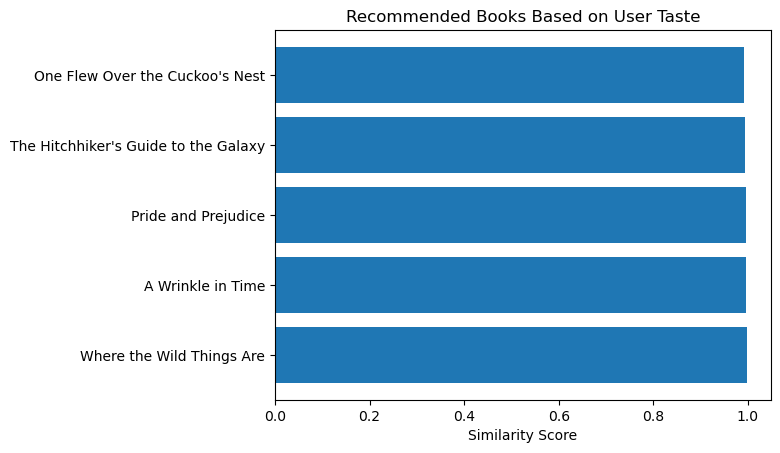

In [228]:
# Recommended Books Based on User Taste
titles = [r[0] for r in results]
scores = [r[1] for r in results]

plt.barh(titles, scores)
plt.xlabel("Similarity Score")
plt.title("Recommended Books Based on User Taste")
plt.show()


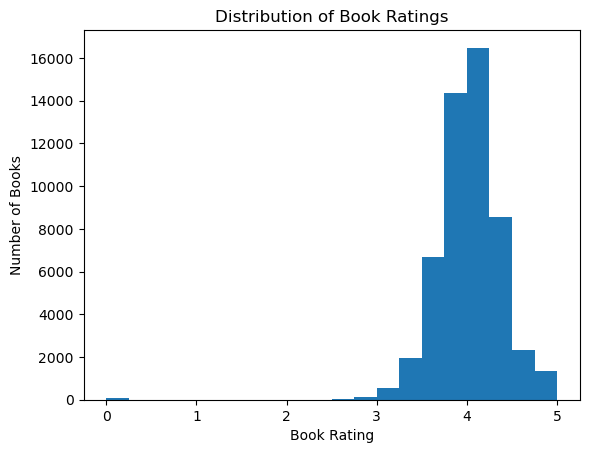

Displayed rating distribution histogram.


In [229]:
# Plot 1: Rating Distribution

plt.figure()
plt.hist(df["rating"], bins=20)
plt.xlabel("Book Rating")
plt.ylabel("Number of Books")
plt.title("Distribution of Book Ratings")
plt.show()

print("Displayed rating distribution histogram.")


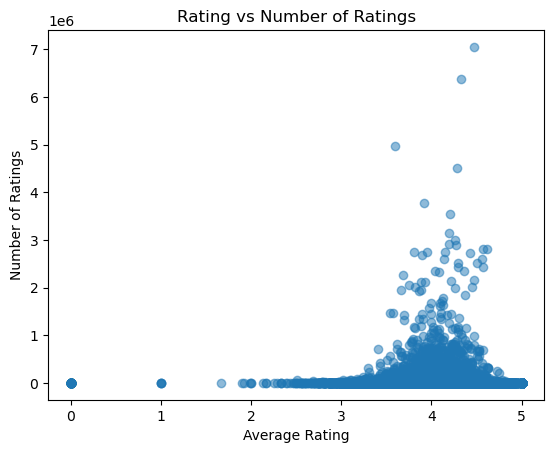

Displayed rating vs number of ratings scatter plot.


In [230]:
# Plot 2: Number of Ratings vs Rating

plt.figure()
plt.scatter(df["rating"], df["numRatings"], alpha=0.5)
plt.xlabel("Average Rating")
plt.ylabel("Number of Ratings")
plt.title("Rating vs Number of Ratings")
plt.show()

print("Displayed rating vs number of ratings scatter plot.")


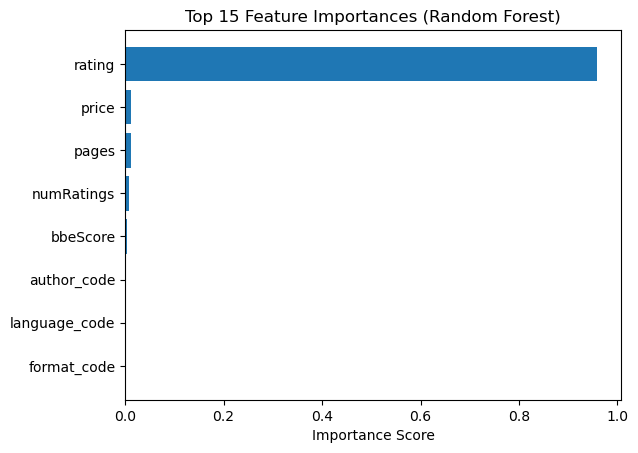

Displayed Random Forest feature importance.


,Feature,Importance
3,rating,0.959365
7,price,0.011706
5,pages,0.011155
4,numRatings,0.008476
6,bbeScore,0.003599
0,author_code,0.002368
2,language_code,0.002226
1,format_code,0.001105


In [231]:
# Plot 3: Feature Importance from Random Forest

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X_scaled.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure()
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

print("Displayed Random Forest feature importance.")
feature_importance_df


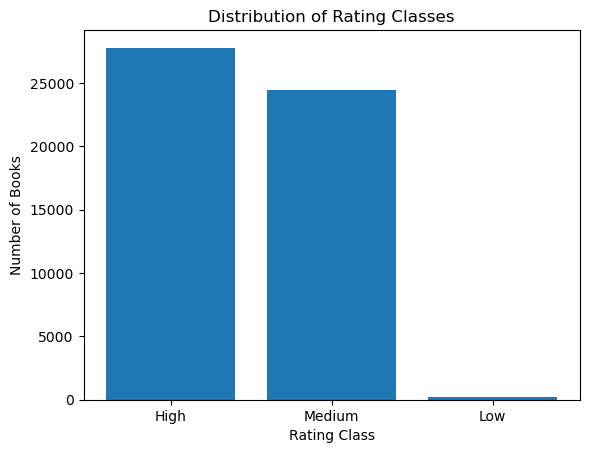

Displayed rating class distribution.


rating_class
High      27772
Medium    24456
Low         250
Name: count, dtype: int64

In [232]:
# Plot 4: Rating Class Distribution

rating_counts = df["rating_class"].value_counts()

plt.figure()
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel("Rating Class")
plt.ylabel("Number of Books")
plt.title("Distribution of Rating Classes")
plt.show()

print("Displayed rating class distribution.")
rating_counts